## CUQIpy component final project

**Note: under construction to be finalized by midnight 21 July 2024** 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cuqi
from cuqi.model import Model #, LinearModel
from cuqi.geometry import MappedGeometry, Continuous1D, KLExpansion #, Geometry, Continuous
from cuqi.distribution import Gaussian
from scipy.linalg import lu_factor, lu_solve

from testBeam import BeamModel1D

np.random.seed(10)

In [16]:
class hydraulic_class():
    def __init__(self, N, L=1, source_idx=0):
        self.L = L
        self.N = N
        self.x = np.linspace(self.L/self.N,1,self.N)
        self.dx = self.L/self.N
        self.source_idx = source_idx
        self.source()

    def forward(self, a):
        diag1 = -(a[1:] + a[:-1])
        diag1 = np.concatenate([diag1,[-a[-1]]])
        diag2 = a[1:]

        Dxx = np.diag(diag1) + np.diag(diag2,-1) + np.diag(diag2,1)
        Dxx /= self.dx*self.dx

        lu, piv = lu_factor(Dxx)

        sol = lu_solve((lu, piv), self.b_terms) 

        return np.array(sol)

    def source(self, n_source=5, std=0.02):
        dist = self.L/(n_source+1)
        source_coords = np.linspace( dist,self.L-dist, n_source )
        self.b_terms =  np.exp( -0.5*(self.x - source_coords[self.source_idx])**2/std/std )/std/np.sqrt(2*np.pi) 


- Create a mapped KL expansion domain geometry with the mapping `lambda x: exp(x)`.
- Create a continuous range geometry for the range.
- Create a user define CUQIpy model representing the forward model (hydraulic).
- Create a Gaussian i.i.d. prior
- Create a Gaussian likelihood (for one injection pattern)
- Create a synthetic data from the given true porosity.
- Create a posterior
- Use MH for sampling
- Use NUTS for sampling
- Compare the results (ess, pair_plot, trace_plot, plot_ci)
- Comment on the computational cost of nuts (tree size, FD)
- Create a posterior with multiple likelihoods (for multiple injection patterns)
- Use MH for sampling
- Comment on how adding more data helped the inference.



CUQI Gaussian Likelihood function. Parameters ['thkVec'].


<bound method Distribution.sample of CUQI Gaussian.>

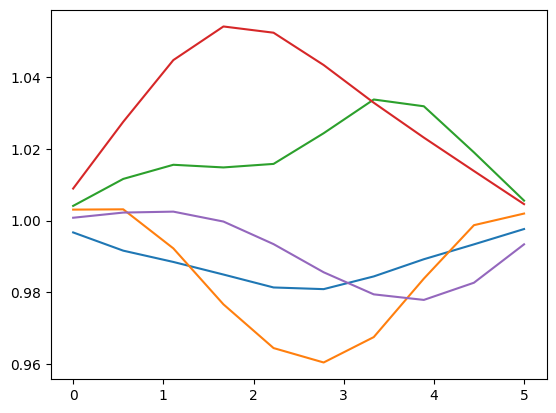

In [21]:
# Data and initialization
U = lambda x: np.exp(x)             # Define mapping
L = 5                               # domain length 1
N_hydro = 128                       # Number of measurement points for hydrolic problem
N_points = 10                       # Number of discretization points
N_modes = 5                         # Number of terms in KL expansion
grid1 = np.linspace(0,L,N_points)   # Discretization for domain

hydraulic = hydraulic_class(N=N_points, L=L)
beam = BeamModel1D(nelx=N_points, Lx=L)

# Create Beam and hydrolic models
model_hydraulic = Model(forward=hydraulic.forward, 
                range_geometry=Continuous1D(grid=grid1),
                domain_geometry=MappedGeometry(KLExpansion( grid=grid1,num_modes=N_modes ), map = U))

model_Beam = Model(forward=beam.forward, 
                range_geometry=Continuous1D(grid=grid1),
                domain_geometry=MappedGeometry(KLExpansion( grid=grid1,num_modes=N_modes ), map = U))

# # Test both mdoels for som input
# print(model_hydraulic(np.ones(5)))
# print(model_Beam(np.ones(5)))

# # Gaussian prior -> test it on beam domain
prior_Zs = Gaussian(0,1,geometry=model_Beam.domain_geometry);
prior_Zs.sample(5).plot();


# Gaussian Likelihood
data_test = np.ones(5)
likelihood = cuqi.distribution.Gaussian(mean=model_Beam, cov=0.05**2).to_likelihood(data_test)
print(likelihood)

In [18]:
# Gaussian Likelihood
data_test = np.ones(5)
likelihood = cuqi.distribution.Gaussian(mean=model_Beam, cov=0.05**2).to_likelihood(data_test)
print(likelihood)

CUQI Gaussian Likelihood function. Parameters ['thkVec'].


In [20]:
# Create sunthetic data
Zs_true = np.random.randn(N_points)/5 # True parameters Zs for beam model
print(Zs_true)
t_true = U(Zs_true) # True beam thickness
print(t_true)

u_true = beam.forward(t_true)


# np.random.seed(10)
# N_points = 128
# measurement = np.load('measurement.npz')
# epsilons = measurement['noise_vec']
# p_true = measurement['p_true']
# X_true= measurement['X_true']

# print(X_true.shape)
# hydraulic = hydraulic_class(N_points)

# X = np.ones(N_points) # create a constant (positive) porosity X
# p = hydraulic.forward(X)

# # constructing noisy vector in y_obs and likelihood standard deviations in sigmas
# y_obs = []
# sigmas = []
# for i in range(p_true.shape[0]):
#     # construct noisy measurements like the previous exercise
#     epsilon = np.random.standard_normal(N_points) # sample a noise vector of size N_points
#     epsilon /= np.linalg.norm(epsilon) # normalize with Euclidean norm
#     sig = 0.05*np.sqrt(np.sum(p_true[i,:]**2*hydraulic.L/N_points))/np.sqrt(N_points) # define 5% noise standard deviation with respect to the L2 norm of the pressure

#     sigmas.append(sig)
#     y_obs.append(  p_true[i,:] + epsilon*sig ) # add noise to p and append
# y_obs = np.array(y_obs)
# sigmas = np.array(sigmas)


[ 0.03900266  0.080042   -0.06752647  0.25129445 -0.1463939   0.13204631
 -0.07017438 -0.18788667 -0.09786744 -0.16091823]
[1.03977325 1.08333256 0.93470298 1.2856886  0.86381738 1.14116117
 0.93223124 0.82870862 0.90676909 0.85136169]


/home/mtaho/miniconda3/envs/cuqitest/lib/python3.12/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [32]:

prior_Zs.sample(1).funvals

CUQIarray: NumPy array wrapped with geometry.
---------------------------------------------

Geometry:
 MappedGeometry(KLExpansion(5,))

Parameters:
 False

Array:
CUQIarray([0.99561855, 0.98809101, 0.98435896, 0.98606371, 0.99151738,
           0.99593226, 0.99580559, 0.99281275, 0.9920567 , 0.99645754])